In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib.colors as colors
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]
e = const.physical_constants['elementary charge'][0]

pathPre = '/home/robert/CU-PWFA/emittance_preservation/simulations/AcceleratorEvolution/'

In [2]:
def alpha_colormap(cmap, cutoff, flip=True):
    N = cmap.N
    cmapt = cmap(np.arange(N))
    alpha = np.ones(N)
    if flip:
        temp = alpha[:int(cutoff*N)]
        M = len(temp)
        alpha[:int(cutoff*N)] = np.linspace(0, 1, M)
    else:
        alpha[int((1-cutoff)*N):] = 0.0
    cmapt[:, -1] = alpha
    cmapt = colors.ListedColormap(cmapt)
    return cmapt

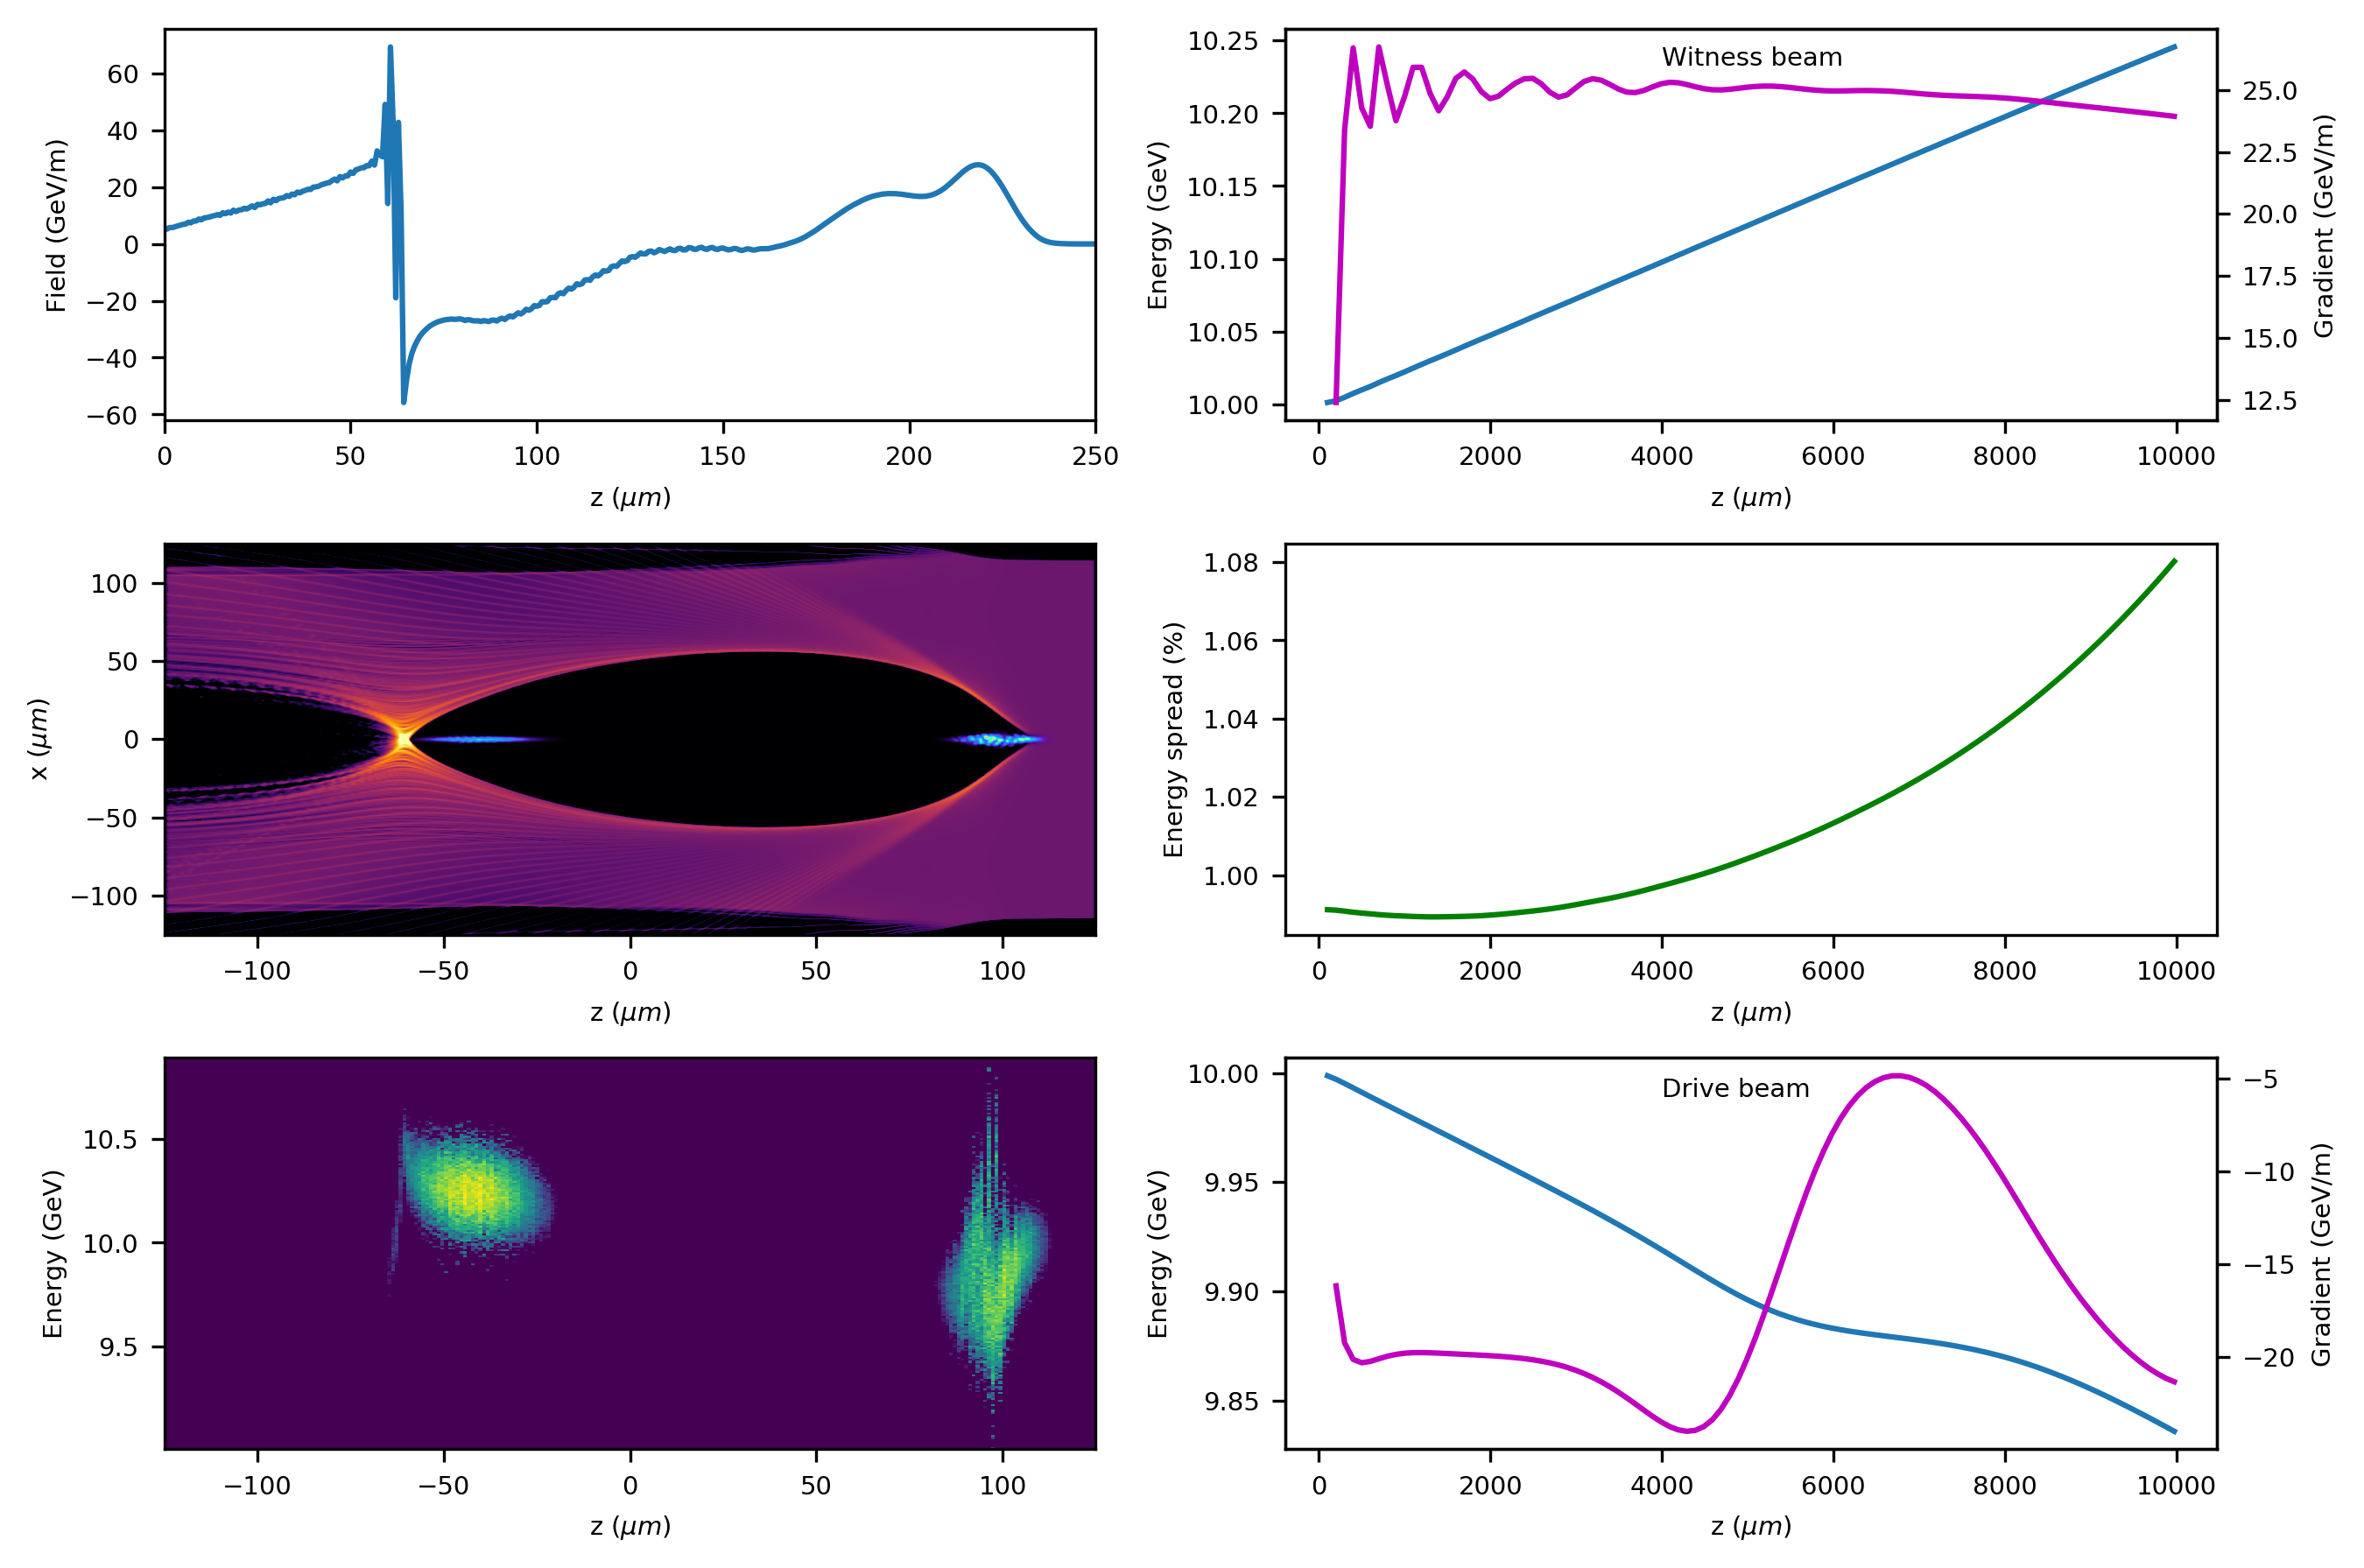

In [3]:
path = pathPre + '140umX7.8um/'
data = np.load(path + 'AcceleratingGradient.npy').item()
gradient = np.average(data['gradient'][5:]/1e3)
density = np.load(path + 'DensitySlice.npy').item()
dataD = np.load(path + 'DecceleratingGradient.npy').item()
gradientD = np.average(data['gradient'][5:]/1e3)

# Load in plasma density
ind = 99
rhoXY = -np.transpose(density['rhoP'][ind]/e/1e6)+2 #+2 makes it greater than 0 for log scale
x = density['xfield']
y = density['yfield']
        
#Load in the beam densities
rhoBXY = -np.transpose(density['rhoB'][ind]/e/1e6)

fig = plt.figure(figsize=(9,6), dpi=300)
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1])
#cax2 = plt.subplot(gs[2, 1], aspect=20, anchor=(0,0.5))


ax1 = plt.subplot(gs[0, 1])
plt.plot(data['x']*1e6, data['energy']/1e3)
plt.ylabel('Energy (GeV)')
plt.xlabel(r'z ($\mu m$)')
plt.twinx()
plt.plot(data['x'][1:]*1e6, data['gradient']/1e3, 'm')
plt.ylabel('Gradient (GeV/m)')
plt.text(4000, 26, 'Witness beam')

plt.subplot(gs[0, 0])
#for k in range(len(data['x'])):
k = 6
plt.plot(data['xfield']*1e6, data['field'][k, :]/1e9, label=('%0.2f' % (data['x'][k]*1e6)))
plt.ylabel('Field (GeV/m)')
plt.xlim(0, 250)
plt.xlabel(r'z ($\mu m$)')

plt.subplot(gs[1, 1])
plt.plot(data['x']*1e6, data['gamma_rms'], 'g')
plt.xlabel(r'z ($\mu m$)')
plt.ylabel('Energy spread (%)')

plt.subplot(gs[2, 1])
plt.plot(dataD['x']*1e6, dataD['energy']/1e3)
plt.ylabel('Energy (GeV)')
plt.xlabel(r'z ($\mu m$)')
plt.twinx()
plt.plot(dataD['x'][1:]*1e6, dataD['gradient']/1e3, 'm')
plt.ylabel('Gradient (GeV/m)')
plt.text(4000, -6, 'Drive beam')
        
ax = plt.subplot(gs[1, 0])
ax.imshow(rhoXY, interpolation='gaussian', aspect='auto', extent=[-125, 125, -125, 125],
           norm=colors.LogNorm(vmin=1e16, vmax=2e18), cmap='inferno')
cmapW = alpha_colormap(plt.cm.get_cmap('rainbow'), 0.1, True)
ax.imshow(rhoBXY, interpolation='gaussian', aspect='auto', extent=[-125, 125, -125, 125], cmap=cmapW)
plt.xlabel(r'z ($\mu m$)')
plt.ylabel(r'x ($\mu m$)')

Ddata = load.get_species_data(path+'MatchedBeams_ElectronBeam_100.h5', 'ElectronBeam')
Dattrs = load.get_species_attrs(path+'MatchedBeams_ElectronBeam_100.h5', 'ElectronBeam')
Wdata = load.get_species_data(path+'MatchedBeams_WitnessBeam_100.h5', 'WitnessBeam')
Wattrs = load.get_species_attrs(path+'MatchedBeams_WitnessBeam_100.h5', 'WitnessBeam')

Ndrive = np.shape(Ddata)[0]
Nwitness = np.shape(Wdata)[0]
z = np.zeros(Ndrive+Nwitness)
E = np.zeros(Ndrive+Nwitness)
w = np.zeros(Ndrive+Nwitness)
z[0:Ndrive] = analyze.get_x(Ddata, 3)
z[Ndrive:] = analyze.get_x(Wdata, 3)
E[0:Ndrive] = analyze.get_ptc_energy(Ddata, me)
E[Ndrive:] = analyze.get_ptc_energy(Wdata, me)
w[0:Ndrive] = analyze.get_weights(Ddata)
w[Ndrive:] = analyze.get_weights(Wdata)

plt.subplot(gs[2, 0])
plt.imshow(np.zeros((100,100)), aspect='auto',extent=[-125, 125, 9, 11])
plt.hist2d(z*1e6-9974, E/1e3, [200, 200], weights=w, norm=colors.LogNorm(vmin=0.2, vmax=20))
#cb = plt.colorbar(cax=cax2)
#cb.set_label('Charge density')
plt.xlabel(r'z ($\mu m$)')
plt.ylabel(r'Energy (GeV)')
plt.xlim(-125, 125)

plt.tight_layout()
plt.show()

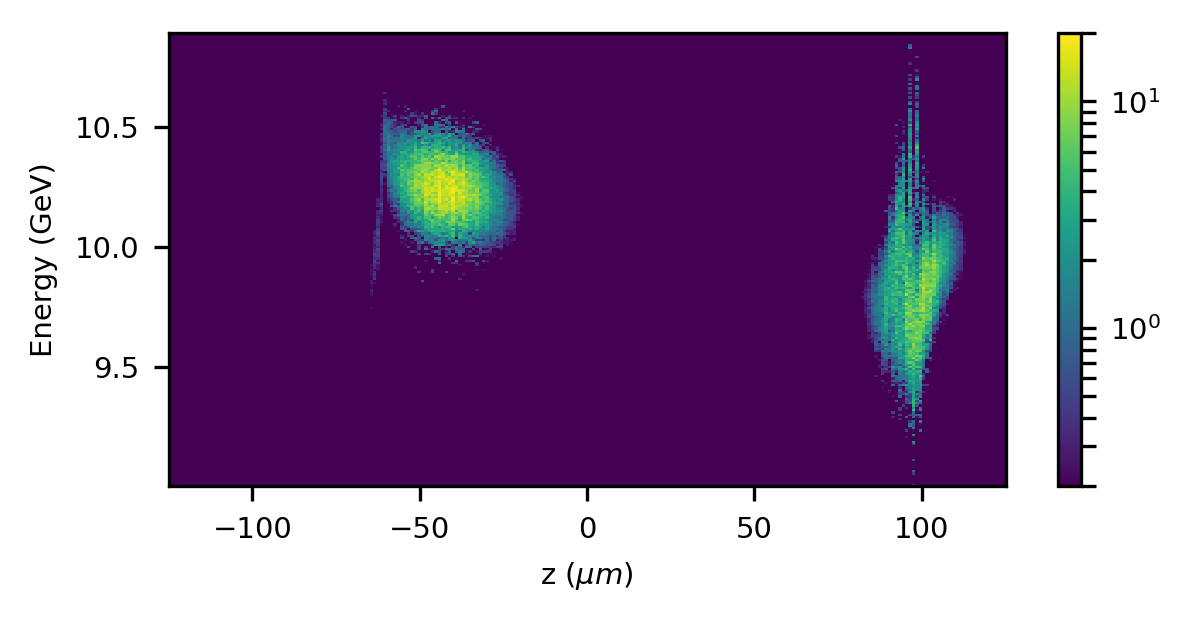

In [4]:
# Look at the longitudinal phase space of the beam
Ddata = load.get_species_data(path+'MatchedBeams_ElectronBeam_100.h5', 'ElectronBeam')
Dattrs = load.get_species_attrs(path+'MatchedBeams_ElectronBeam_100.h5', 'ElectronBeam')
Wdata = load.get_species_data(path+'MatchedBeams_WitnessBeam_100.h5', 'WitnessBeam')
Wattrs = load.get_species_attrs(path+'MatchedBeams_WitnessBeam_100.h5', 'WitnessBeam')

Ndrive = np.shape(Ddata)[0]
Nwitness = np.shape(Wdata)[0]
z = np.zeros(Ndrive+Nwitness)
E = np.zeros(Ndrive+Nwitness)
w = np.zeros(Ndrive+Nwitness)
z[0:Ndrive] = analyze.get_x(Ddata, 3)
z[Ndrive:] = analyze.get_x(Wdata, 3)
E[0:Ndrive] = analyze.get_ptc_energy(Ddata, me)
E[Ndrive:] = analyze.get_ptc_energy(Wdata, me)
w[0:Ndrive] = analyze.get_weights(Ddata)
w[Ndrive:] = analyze.get_weights(Wdata)

plt.figure(figsize=(4.5,2), dpi=300)
plt.imshow(np.zeros((100,100)), aspect='auto',extent=[-125, 125, 9, 11])
plt.hist2d(z*1e6-9974, E/1e3, [200, 200], weights=w, norm=colors.LogNorm(vmin=0.2, vmax=20))
cd = plt.colorbar()
plt.xlabel(r'z ($\mu m$)')
plt.ylabel(r'Energy (GeV)')
plt.xlim(-125, 125)
plt.show()

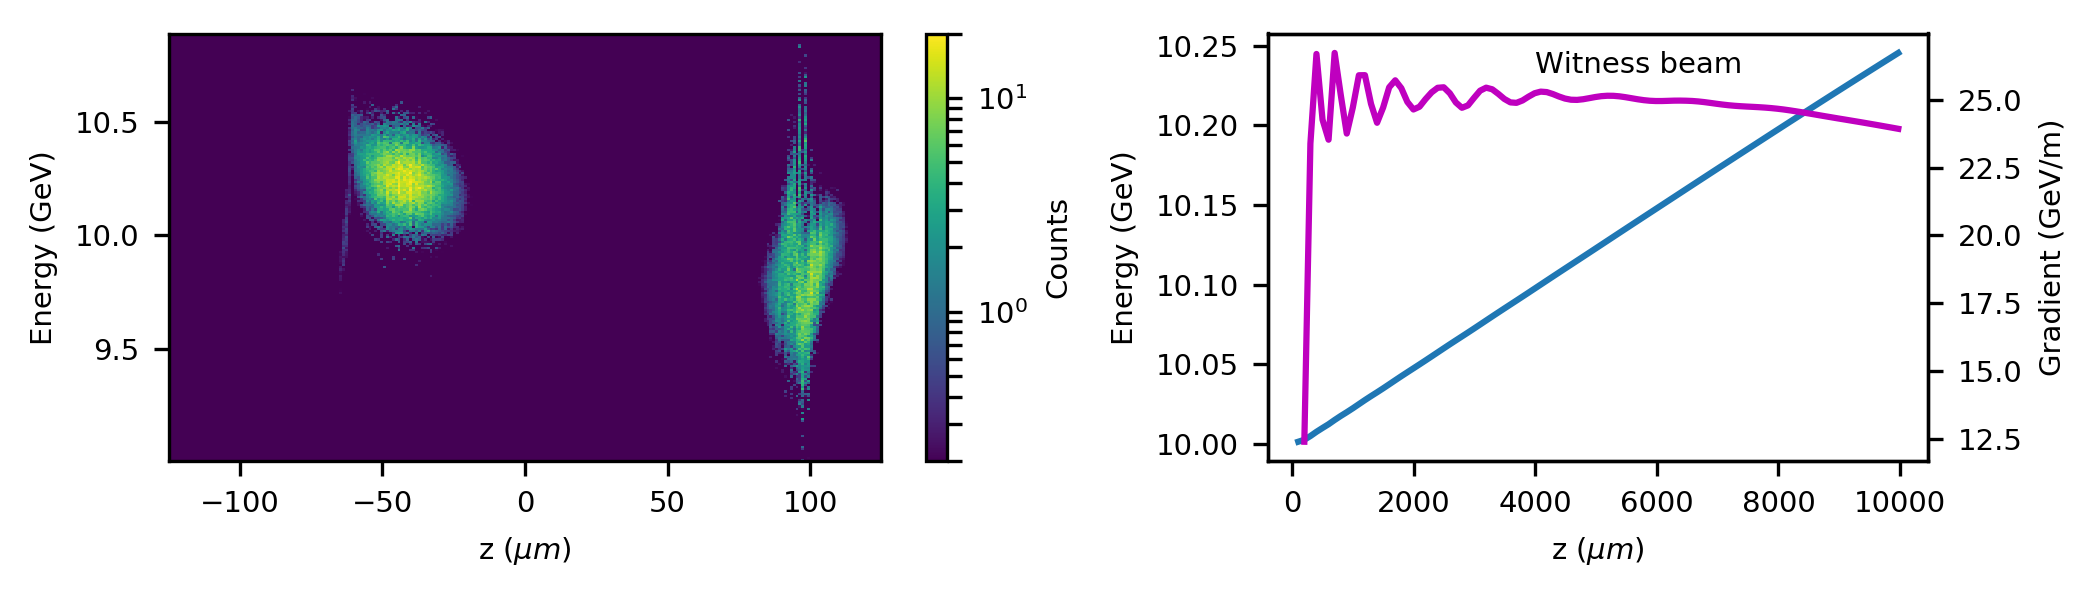

In [36]:
# Look at the longitudinal phase space of the beam
Ddata = load.get_species_data(path+'MatchedBeams_ElectronBeam_100.h5', 'ElectronBeam')
Dattrs = load.get_species_attrs(path+'MatchedBeams_ElectronBeam_100.h5', 'ElectronBeam')
Wdata = load.get_species_data(path+'MatchedBeams_WitnessBeam_100.h5', 'WitnessBeam')
Wattrs = load.get_species_attrs(path+'MatchedBeams_WitnessBeam_100.h5', 'WitnessBeam')

Ndrive = np.shape(Ddata)[0]
Nwitness = np.shape(Wdata)[0]
z = np.zeros(Ndrive+Nwitness)
E = np.zeros(Ndrive+Nwitness)
w = np.zeros(Ndrive+Nwitness)
z[0:Ndrive] = analyze.get_x(Ddata, 3)
z[Ndrive:] = analyze.get_x(Wdata, 3)
E[0:Ndrive] = analyze.get_ptc_energy(Ddata, me)
E[Ndrive:] = analyze.get_ptc_energy(Wdata, me)
w[0:Ndrive] = analyze.get_weights(Ddata)
w[Ndrive:] = analyze.get_weights(Wdata)

plt.figure(figsize=(7,2), dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.35, 1])
plt.subplot(gs[0, 0])
plt.imshow(np.zeros((100,100)), aspect='auto',extent=[-125, 125, 9, 11])
plt.hist2d(z*1e6-9974, E/1e3, [200, 200], weights=w, norm=colors.LogNorm(vmin=0.2, vmax=20))
cd = plt.colorbar()
cd.set_label('Counts')
plt.xlabel(r'z ($\mu m$)')
plt.ylabel(r'Energy (GeV)')
plt.xlim(-125, 125)

plt.subplot(gs[0, 1])
plt.plot(data['x']*1e6, data['energy']/1e3)
plt.ylabel('Energy (GeV)')
plt.xlabel(r'z ($\mu m$)')
plt.twinx()
plt.plot(data['x'][1:]*1e6, data['gradient']/1e3, 'm')
plt.ylabel('Gradient (GeV/m)')
plt.text(4000, 26, 'Witness beam')
plt.tight_layout()
plt.show()

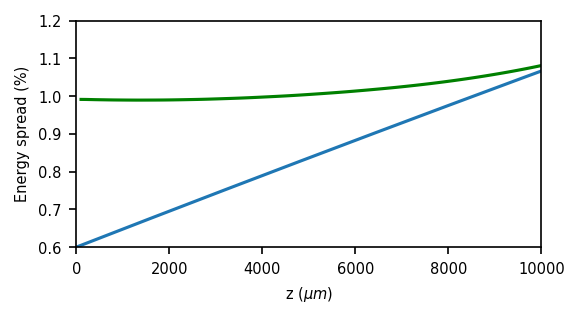

In [31]:
# Let's comapre the energy spread growth with the simple model
pathPre2 = '/home/robert/CU-PWFA/emittance_preservation/simulations/WitnessDelay/'
path2 = pathPre2 + '140umX7.8um/'
data2 = np.load(path2 + 'AcceleratingGradient.npy').item()

k = 6
# Calculate the standard deviation in energy after acceleration
center = 250-140-26
centerInd = int(center*350/250)
size = 5*7.8
beamDensity = np.exp(-(data['xfield']*1e6-center)**2/(2*7.8**2))
L = np.reshape(np.linspace(0, 0.4, 1000), (1000, 1))
finalE = -data['field'][k, :]/1e9 * L + 10.0
Eavg = np.average(finalE, weights=beamDensity, axis=1)
Estd = np.sqrt(np.average((finalE-np.reshape(Eavg, (1000, 1)))**2, weights=beamDensity, axis=1))
Erel = Estd/Eavg*100

plt.figure(figsize=(4,2), dpi=150)
plt.plot(L*1e6, Erel+.6)
plt.plot(data['x']*1e6, data['gamma_rms'], 'g')
plt.xlabel(r'z ($\mu m$)')
plt.ylabel('Energy spread (%)')
plt.xlim(0, 10000)
plt.ylim(0.6, 1.2)
plt.show()
# The only thing we can really say from this is that the slope isn't unreasonable